In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from utils import *


DATA_DIR = Path("out")
FIGURES_DIR = Path("figures")

### METG per Num Devices

In [ ]:
rsys = 'mpi'
accl = 'mi300a'
devices_per_worker = 1
date = '09_07_25'

bench =  f'tb_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='workers', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='workers')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

# df.query('workers == 1')
df

In [ ]:
agg_df = df.groupby(by=['devices', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    runtime_std=('wall_time', 'std')
).reset_index()


agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by='devices', as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on='devices')
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
agg_df

In [ ]:
plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='devices',
    style='devices',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)


In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='devices',
    style='devices',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    # xticks=df['task_granularity'].astype(str).unique(),
    xticks=[],
    # yticks=['0%', '25%', '50%', '75%', '100%'],
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
# Get METG(50%)
metg_df = agg_df[['devices', 'task_granularity', 'efficiency']].groupby('devices').apply(find_metg, include_groups=False).reset_index()

plot_meta = PlotMeta(
    x_axis='devices',
    y_axis='metg',
    hue=None,
    style=None,
    xlabel='Number of Devices',
    ylabel='Minimum Efficient Task Granularity (ms)',
    xticks=[],
    yticks=[],
    legend_title='',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale=False,
)

In [ ]:
benchs = [
    'tb_mpp_h100_08_07_25',
    'tb_mpp_mi300a_08_07_25',
    'tb_mpi_h100_09_07_25',
    'tb_mpi_mi300a_09_07_25',

]

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices'], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'task_granularity', 'efficiency']].groupby(['sys', 'accl', 'devices']).apply(find_metg, include_groups=False).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()

plot_meta = PlotMeta(
    x_axis='devices',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Number of Devices',
    ylabel='METG(50%) (ms)',
    xticks=[],
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
)

In [ ]:
metg_df

### METG per Num Deps

In [ ]:
rsys = 'mpi'
accl = 'mi300a'
devices_per_worker = 1
date = '10_07_25'

bench =  f'tb_deps_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='workers', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='workers')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    runtime_std=('wall_time', 'std')
).reset_index()


agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by='radix', as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on='radix')
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
agg_df.query('radix == 9')

In [ ]:
plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='radix',
    style='radix',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Num Deps',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_deps_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='radix',
    style='radix',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Num Deps',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_deps_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_deps_mpp_h100_10_07_25',
    'tb_deps_mpp_mi300a_10_07_25',
    'tb_deps_mpi_h100_10_07_25',
    'tb_deps_mpi_mi300a_10_07_25',
]

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'radix'], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'radix'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'radix', 'task_granularity', 'efficiency']].groupby(['sys', 'accl', 'devices', 'radix']).apply(find_metg, include_groups=False).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()

plot_meta = PlotMeta(
    x_axis='radix',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Number of Deps',
    ylabel='METG(50%) (ms)',
    xticks=[],
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'deps_metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
)

### METG Comm

In [ ]:
rsys = 'mpp'
accl = 'mi300a'
devices_per_worker = 1
date = '10_07_25'

bench =  f'tb_comm_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='workers', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='workers')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by='output', as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on='output')
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

In [ ]:
plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='output',
    style='output',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_comm_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='output',
    style='output',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_comm_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_comm_mpp_h100_10_07_25',
    'tb_comm_mpp_mi300a_10_07_25',
    'tb_comm_mpi_h100_10_07_25',
    'tb_comm_mpi_mi300a_10_07_25',
]

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'output'], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'radix', 'output'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'radix', 'output', 'task_granularity', 'efficiency']].groupby(
    ['sys', 'accl', 'devices', 'radix', 'output']).apply(find_metg, include_groups=False
).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()

plot_meta = PlotMeta(
    x_axis='output',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Output Size ($2^{x}$)',
    ylabel='METG(50%) (ms)',
    xticks=[],
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'com_metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
)

### METG Scalability

In [ ]:
rsys = 'mpi'
accl = 'h100'
devices_per_worker = 1
date = '13_07_25'

bench =  f'tb_scal_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

df['devices'] = df['workers'] * devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='workers', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='workers')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'output', 'size', 'type', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by=['devices', 'type'], as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on=['devices', 'type'])
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

In [ ]:
type = 'stencil_1d'

plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='devices',
    style='devices',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df.query('type == @type'),
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_scal_{type}_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='devices',
    style='devices',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Num Devices',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df.query('type == @type'),
    # dataset=df.query('workers == 1'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_scal_{type}_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_scal_mpp_h100_10_07_25',
    'tb_scal_mpp_mi300a_10_07_25',
    'tb_scal_mpi_h100_13_07_25',
    'tb_scal_mpi_mi300a_11_07_25',
]

devices_per_worker = 1

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'output', 'type', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'radix', 'output', 'type'], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'radix', 'output', 'type'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'radix', 'output', 'type', 'task_granularity', 'efficiency']].groupby(
    ['sys', 'accl', 'devices', 'radix', 'output', 'type']).apply(find_metg, include_groups=False
).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper() + "-" + metg_df['type'].str.upper()

plot_meta = PlotMeta(
    x_axis='devices',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Num Devices',
    ylabel='METG(50%) (ms)',
    xticks=metg_df['devices'].astype('str').unique(),
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'scal_metg_line_2.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
    outside_legend=True,
)

### METG SCOMM

In [ ]:
rsys = 'mpi'
accl = 'mi300a'
devices_per_worker = 1
date = '14_07_25'

bench =  f'tb_scomm_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
# df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

# df['devices'] = df['workers'] * devices_per_worker
df['devices'] = devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='devices', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='devices')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'type', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by=['devices', 'output'], as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on=['devices', 'output'])
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

In [ ]:

plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='output',
    style='output',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_scomm_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

In [ ]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='output',
    style='output',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    # dataset=df.query('workers == 1'),
    dataset=agg_df,
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_scomm_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [ ]:
benchs = [
    'tb_scomm_mpp_h100_14_07_25',
    'tb_scomm_mpp_mi300a_14_07_25',
    'tb_scomm_mpi_h100_14_07_25_2',
    'tb_scomm_mpi_mi300a_14_07_25',
]

devices_per_worker = 1

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'type', 'radix', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'type', 'radix', 'output', ], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'type', 'radix', 'output'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

In [ ]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'type', 'radix', 'output', 'task_granularity', 'efficiency']].groupby(
    ['sys', 'accl', 'devices', 'type', 'radix', 'output']).apply(find_metg, include_groups=False
).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()
metg_df = metg_df[metg_df['output'] < 30]

plot_meta = PlotMeta(
    x_axis='output',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Output Size ($2^{x}$)',
    ylabel='METG(50%) (ms)',
    xticks=metg_df['output'].astype('str').unique(),
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'scomm_metg_line_2.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
    outside_legend=True,
)

### METG COMM Stencil

In [7]:
rsys = 'mpp'
accl = 'h100'
devices_per_worker = 10
date = '14_07_25'

bench =  f'tb_comm_stencil_{rsys}_{accl}_{date}'

dashes = False
df, metadata = load_data(DATA_DIR/f"{bench}.pkl")
# df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)

# df['devices'] = df['workers'] * devices_per_worker
df['devices'] = devices_per_worker
df['tflops_per_sec'] = df['total_flops'] * np.pow(1/10, 12) / df['wall_time']
df['tflops_per_task'] = df['total_flops'] * np.pow(1/10, 12) / df['total_tasks']
df_max_flops_per_worker = df.groupby(by='devices', as_index=False)['tflops_per_sec'].max()
df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
df = df.merge(df_max_flops_per_worker, on='devices')
df['efficiency'] = df['tflops_per_sec'] * 100 /df['max_tflops_per_sec']
df['task_granularity'] = df['wall_time'] * df['devices'] * np.pow(10, 3) / df['total_tasks']

agg_df = df.groupby(by=['devices', 'radix', 'type', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_df['tflops_per_sec'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['runtime_mean']
agg_df['tflops_per_task'] = agg_df['total_flops'] * np.pow(1/10, 12) / agg_df['total_tasks']
agg_df_max_flops_per_worker = agg_df.groupby(by=['devices', 'output'], as_index=False)['tflops_per_sec'].max()
agg_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_df = agg_df.merge(agg_df_max_flops_per_worker, on=['devices', 'output'])
agg_df['efficiency'] = agg_df['tflops_per_sec'] * 100 /agg_df['max_tflops_per_sec']
agg_df['task_granularity'] = agg_df['runtime_mean'] * agg_df['devices'] * np.pow(10, 3) / agg_df['total_tasks']
# agg_df.query('output == 16')
agg_df

,devices,radix,type,output,size,total_flops,total_tasks,runtime_mean,tflops_per_sec,tflops_per_task,max_tflops_per_sec,efficiency,task_granularity
0,10,5,stencil_1d,4,0,2638827906662400,300,54.59196,48.337299,8.796093,48.339477,99.995494,1819.732
1,10,5,stencil_1d,4,1,1319413953331200,300,27.29475,48.339477,4.398047,48.339477,100.0,909.825
2,10,5,stencil_1d,4,2,659706976665600,300,13.69501,48.17134,2.199023,48.339477,99.652173,456.500333
3,10,5,stencil_1d,4,3,329853488332800,300,6.9695,47.328142,1.099512,48.339477,97.907848,232.316667
4,10,5,stencil_1d,4,4,164926744166400,300,3.53101,46.708093,0.549756,48.339477,96.625151,117.700333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,10,5,stencil_1d,28,15,80530636800,300,1.306827,0.061623,0.000268,47.60724,0.12944,43.5609
136,10,5,stencil_1d,28,16,40265318400,300,1.090144,0.036936,0.000134,47.60724,0.077584,36.338133
137,10,5,stencil_1d,28,17,20132659200,300,1.039083,0.019375,0.000067,47.60724,0.040698,34.6361
138,10,5,stencil_1d,28,18,10066329600,300,0.717744,0.014025,0.000034,47.60724,0.02946,23.924803


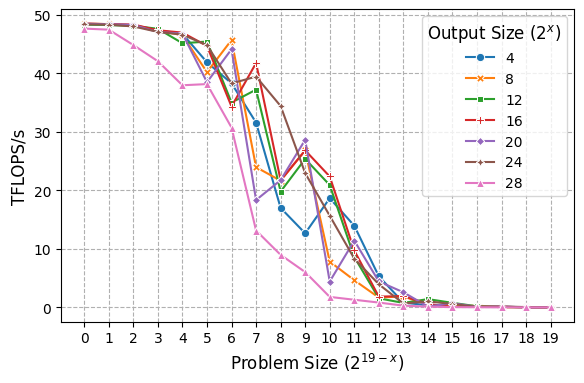

In [8]:
plot_meta = PlotMeta(
    x_axis='size',
    y_axis='tflops_per_sec',
    hue='output',
    style='output',
    xlabel='Problem Size ($2^{19-x}$)',
    ylabel='TFLOPS/s',
    xticks=agg_df['size'].astype(str).unique(),
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    dataset=agg_df,
    # dataset=df.query('workers == 8'),
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_comm_stencil_tfps.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
)

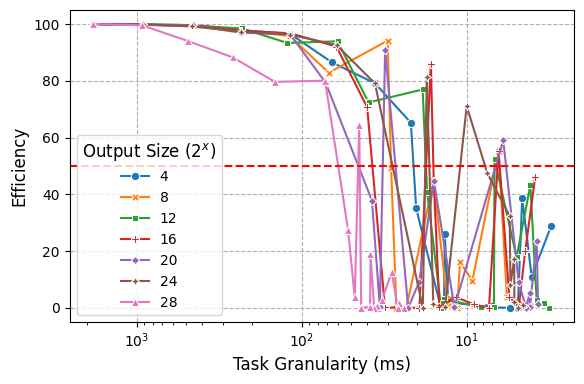

In [9]:
plot_meta = PlotMeta(
    x_axis='task_granularity',
    y_axis='efficiency',
    hue='output',
    style='output',
    xlabel='Task Granularity (ms)',
    ylabel='Efficiency',
    xticks=[],
    yticks=[],
    legend_title='Output Size ($2^{x}$)',
    legend_labels=[],
)


generic_line_plot_err_bar(
    # dataset=df.query('workers == 1'),
    dataset=agg_df,
    title='',
    output_file=FIGURES_DIR/f'{rsys}_{accl}_{date}_comm_stencil_metg.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=True,
    log_scale=True,
)

In [10]:
benchs = [
    'tb_comm_stencil_mpp_h100_14_07_25',
    'tb_comm_stencil_mpp_mi300a_14_07_25',
    'tb_comm_stencil_mpi_h100_14_07_25',
    'tb_comm_stencil_mpi_mi300a_14_07_25',
]

devices_per_worker = 10

all_df = pd.concat([load_data(DATA_DIR/f"{bench}.pkl")[0] for bench in benchs])
all_df['sys'] = all_df['version'].apply(lambda x: 'mpi' if 'mpi' in x else 'mpp')
all_df['accl'] = all_df['version'].apply(lambda x: 'h100' if 'h100' in x else 'mi300a')
all_df['devices'] = devices_per_worker
# all_df['devices'] = all_df['workers'] * devices_per_worker
all_df.drop(columns=['name', 'kernel', 'version', 'hosts', 'time'], inplace=True)


agg_all_df = all_df.groupby(by=['sys', 'accl', 'devices', 'type', 'radix', 'output', 'size', 'total_flops', 'total_tasks']).agg(
    runtime_mean=('wall_time', 'mean'),
    # runtime_std=('wall_time', 'std')
).reset_index()

agg_all_df['tflops_per_sec'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['runtime_mean']
agg_all_df['tflops_per_task'] = agg_all_df['total_flops'] * np.pow(1/10, 12) / agg_all_df['total_tasks']
agg_all_df_max_flops_per_worker = agg_all_df.groupby(by=['sys', 'accl', 'devices', 'type', 'radix', 'output', ], as_index=False)['tflops_per_sec'].max()
agg_all_df_max_flops_per_worker.rename(columns={'tflops_per_sec': 'max_tflops_per_sec'}, inplace=True)
agg_all_df = agg_all_df.merge(agg_all_df_max_flops_per_worker, on=['sys', 'accl', 'devices', 'type', 'radix', 'output'])
agg_all_df['efficiency'] = agg_all_df['tflops_per_sec'] * 100 /agg_all_df['max_tflops_per_sec']
agg_all_df['task_granularity'] = agg_all_df['runtime_mean'] * agg_all_df['devices'] * np.pow(10, 3) / agg_all_df['total_tasks']
agg_all_df

,sys,accl,devices,type,radix,output,size,total_flops,total_tasks,runtime_mean,tflops_per_sec,tflops_per_task,max_tflops_per_sec,efficiency,task_granularity
0,mpi,h100,10,stencil_1d,5,4,0,2638827906662400,300,54.3516,48.551062,8.796093,48.556655,99.988482,1811.72
1,mpi,h100,10,stencil_1d,5,4,1,1319413953331200,300,27.17267,48.556655,4.398047,48.556655,100.0,905.755667
2,mpi,h100,10,stencil_1d,5,4,2,659706976665600,300,13.58705,48.554099,2.199023,48.556655,99.994738,452.901667
3,mpi,h100,10,stencil_1d,5,4,3,329853488332800,300,6.795364,48.540959,1.099512,48.556655,99.967676,226.512133
4,mpi,h100,10,stencil_1d,5,4,4,164926744166400,300,3.399062,48.521252,0.549756,48.556655,99.92709,113.302067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,mpp,mi300a,10,stencil_1d,5,30,15,80530636800,300,4.636937,0.017367,0.000268,257.292501,0.00675,154.564567
596,mpp,mi300a,10,stencil_1d,5,30,16,40265318400,300,4.641387,0.008675,0.000134,257.292501,0.003372,154.7129
597,mpp,mi300a,10,stencil_1d,5,30,17,20132659200,300,4.731203,0.004255,0.000067,257.292501,0.001654,157.706767
598,mpp,mi300a,10,stencil_1d,5,30,18,10066329600,300,4.713466,0.002136,0.000034,257.292501,0.00083,157.115533


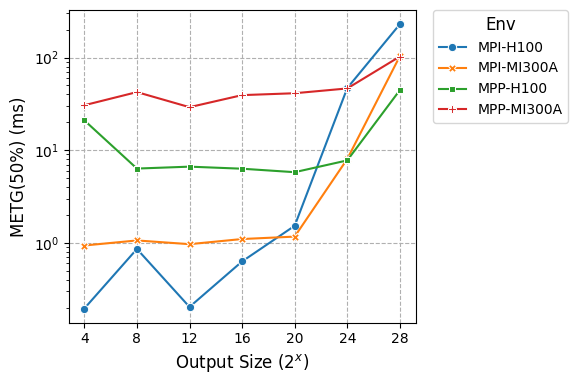

In [11]:
# Get METG(50%)
metg_df = agg_all_df[['sys', 'accl', 'devices', 'type', 'radix', 'output', 'task_granularity', 'efficiency']].groupby(
    ['sys', 'accl', 'devices', 'type', 'radix', 'output']).apply(find_metg, include_groups=False
).reset_index()

metg_df['config'] = metg_df['sys'].str.upper() + "-" + metg_df['accl'].str.upper()
metg_df = metg_df[metg_df['output'] < 30]

plot_meta = PlotMeta(
    x_axis='output',
    y_axis='metg',
    hue='config',
    style='config',
    xlabel='Output Size ($2^{x}$)',
    ylabel='METG(50%) (ms)',
    xticks=metg_df['output'].astype('str').unique(),
    yticks=[],
    legend_title='Env',
    legend_labels=[],
)

generic_line_plot_err_bar(
    dataset=metg_df,
    title='',
    output_file=FIGURES_DIR/f'comm_stencil_metg_line.pdf',
    plot_meta=plot_meta,
    dashes=dashes,
    fifty_percent_line=False,
    log_scale_y=True,
    outside_legend=True,
)